**ESTE ARCHIVO ES UN DUPLICADO, PAR APROBAR CON KMEANS EN LUGAR DE KMEDOIDS**

**Aqui añado mi parte para luego juntarla al informe_v1**

In [1]:
#las librerias que yo uso son 


###########################################
import numpy as np
import matplotlib.pyplot as plt  
import os 
from sklearn.cluster import KMeans 
from sklearn_extra.cluster import KMedoids  
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

from scipy.spatial.distance import cdist

############################################
#cargar librerias y datos

#lo basico
import numpy as np 
import matplotlib.pyplot as plt
import scipy
import pandas as pd


#clustering
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn_extra.cluster import KMedoids
#supervisado
from sklearn.tree import DecisionTreeClassifier ,plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC,LinearSVC

#crossval y parameter estimation
from sklearn.model_selection import KFold,cross_validate, train_test_split, cross_val_score, \
                                    GridSearchCV

#metricas y preprocesado y tal
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler
from sklearn.metrics import confusion_matrix, accuracy_score,roc_auc_score,cohen_kappa_score,f1_score, \
                            precision_score,recall_score,make_scorer


#miscelanea
from sklearn.utils import shuffle


In [50]:
# las funciones que uso son

def get_closer_points(medias,data,n):
    # a esta funcion le pasamos las posiciones de los puntos y de las medias,
    # y nos devuelve un vector logico diciendo que n puntos son los mas cercanos a las medias
    #las distancias entre las medias y los puntos son 
    distancias=cdist(medias,data)

    #y queremos solo nos n puntos mas cercanos a cualquiera de estas
    #primero los juntamos pero guardando donde deben ser separados
    leng=distancias.shape[1]
    aux_dists=np.concatenate(distancias,axis=0)
    indices_aux_dist=np.argsort(aux_dists)
    #ahora queremos un vector de boleanos que nos diga cuales son los que vamos a considerar
    aux_bool=np.full(( indices_aux_dist.shape[-1]), False, dtype=bool)
    aux_bool[indices_aux_dist[:n]]=True
    # y le volvemos a dar la forma
    aux_bool=aux_bool.reshape(-1,leng)

    #por ultimo lo coloreamos escogemos si esta cerca de cualquiera de las medias, 
    #entonces hacermo sentancia or/any para la dimension 1
    points_represent=np.any(aux_bool,axis=0) #el axis este no lo entiendo...
    return points_represent


def train_and_get_stats(model,X_train,y_train,X_test,y_test,cv=5,train=False):
    #vamos a hacer una funcion que nos reciba el modelo, los datos y algunos parametros más, y nos evalue todo esto
    #asi nos lo devuelve y ya lo tenemos para meterlo en el dataframe

    #esta funcion va a tomar el modelo, lo va a entrenar y va a darnos las metricas,
    #pero no va a hacer nada sobre la busqueda de parametros optimos
    
    
    #calculamos en train y test de forma normal con los conjuntos train y test
    if train:
        model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    
    #calculamos las metricas que nos hacen falta
    aux1=pd.Series({"Accuracy_train":accuracy_score(y_train,y_pred_train),
                      "Accuracy_test":accuracy_score(y_test,y_pred_test),
                      "Precision_test":precision_score(y_test,y_pred_test,average="micro"),
                      "Recall_test":recall_score(y_test,y_pred_test,average="micro"),
                      "cohen-kappa_train":cohen_kappa_score(y_train,y_pred_train),
                      "cohen-kappa_test":cohen_kappa_score(y_test,y_pred_test),
                      "f1_test":f1_score(y_test,y_pred_test,average="micro")})
                      #"roc-auc_test":roc_auc_score(y_test,y_pred_test)})

    
    #Tambien vamos a usar cross validation para obtener una estimacion más correcta de los parametros
    prec = make_scorer(precision_score,greater_is_better=True, average="micro")
    recall = make_scorer(recall_score,greater_is_better=True, average="micro")
    f1 = make_scorer(f1_score,greater_is_better=True, average="micro")


    metrics_aux=cross_validate(model, X_train,y_train,cv=cv,
                               scoring={"accuracy":"accuracy","precision":prec,
                                        "recall":recall,"f1":f1},
                               return_train_score=False)
    #obtenemos un diccionario y listas de las estadisticas para cada una de las evaluaciones en los k folds
    #ahora para guardarlos hacemos la media de estas
    
    aux2=pd.Series({"Accuracy_kfold":np.mean(metrics_aux["test_accuracy"]),
                                "Precision_kfold":np.mean(metrics_aux["test_precision"]),
                                "Recall_kfold":np.mean(metrics_aux["test_recall"]),
                                "f1_kfold":np.mean(metrics_aux["test_f1"])})

    return pd.concat([aux1,aux2])


# Primera parte: Estudio de los métodos para la reducción de datos.  

En el enunciado se pide que reduzcamos la cantidad de datos disponibles mediante alguna técnica de aprendizaje no supervisado, para así obtener un 50% compuesto de respresentantes de cada clase.   
Así pues, en este apartado vamos a estudiar como se puede realizar la reducción del conjunto de entrenamiento al 50% de la mejor manera posible.  
Las opciones que se barajan son:  
* Uso de KMeans para localizar representantes de cada clase.  
* Uso de KMedoids para lo mismo, pero ahora los representantes son directamente elementos del conjunto.  
* Uso de gausianas, buscar los puntos más promedio posible al hacer el ajuste de los valores a gausianas.  

También contamos con dos estrategias posibles:  
1. Podemos seleccionar tantos centroides o medioides o gaussianas como representantes queremos obtener (el 50% del total).  
2. Podemos intenter ajustar los datos a un número óptimo de clusters, y seleccionar los puntos con menos distancia a estas posiciones centrales.  

Primero investiguemos cual de estas dos estrategias parece tener mejores resultados, usando unos datos simulados.  

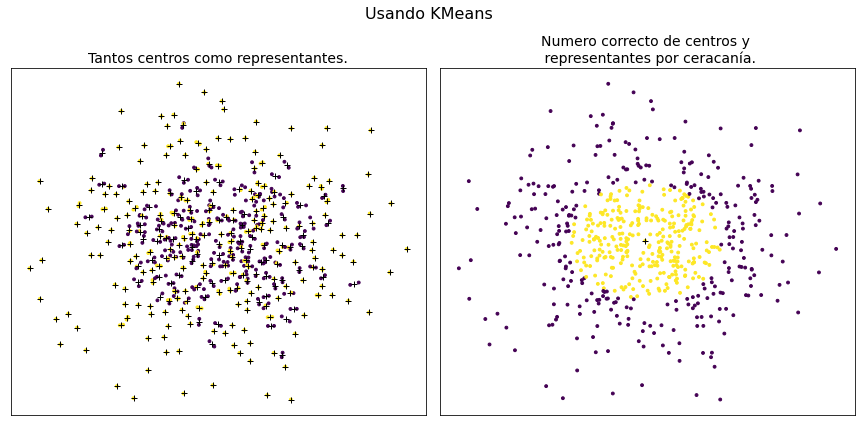

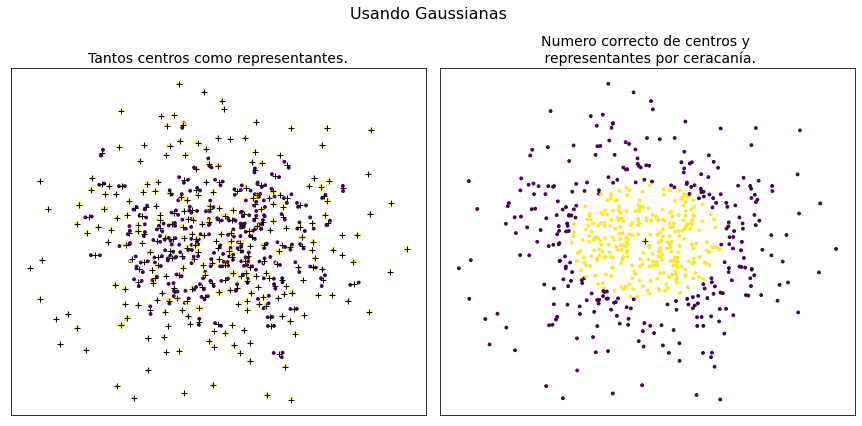

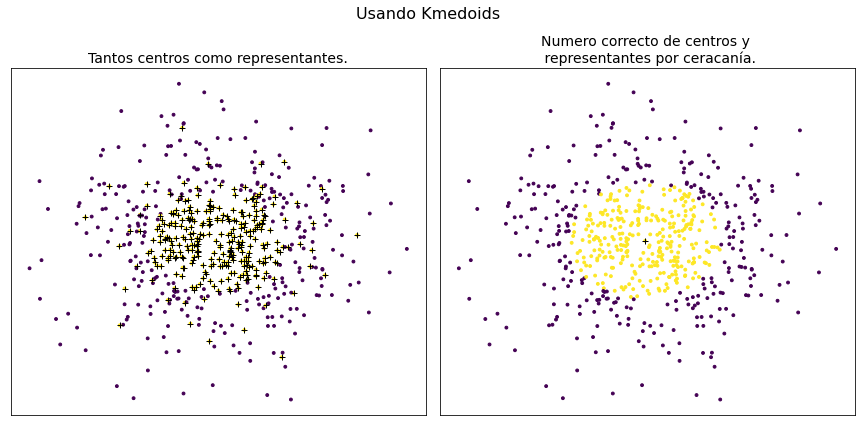

In [3]:
#vamos a hacer un ejemplo sencillo con ambas estrategias 
#para los tres métodos (KMeans, Kmedoids, Gaussians)

#primero creamos los datos 
n=600
data=make_blobs(n,centers=1,cluster_std=1.5)


#primero para KMeans
fig=plt.figure(figsize=(24,6))
n_clusters=[300,1]
titles=["Tantos centros como representantes.","Numero correcto de centros y \n representantes por ceracanía."]

for j,i in enumerate(n_clusters):
    plt.subplot(1,4,j+1)
    modelmeans=KMeans(n_clusters=i)
    modelmeans.fit(data[0])

    points_represent=get_closer_points(modelmeans.cluster_centers_,data[0],n=300)
    plt.scatter(data[0][:,0],data[0][:,1],c=points_represent,s=8)
    plt.plot(modelmeans.cluster_centers_[:,0],modelmeans.cluster_centers_[:,1],"+k")
    plt.title(titles[j],fontsize=14)
    plt.xticks([]);
    plt.yticks([]);
plt.suptitle("Usando KMeans",fontsize=16,x=0.25)
plt.tight_layout()

#segundo para las Gaussianas
fig=plt.figure(figsize=(24,6))
n_clusters=[300,1]
titles=["Tantos centros como representantes.","Numero correcto de centros y \n representantes por ceracanía."]

for j,i in enumerate(n_clusters):
    plt.subplot(1,4,j+1)
    modelgaus=GaussianMixture(n_components=i)
    modelgaus.fit(data[0])
    points_represent=get_closer_points(modelgaus.means_,data[0],n=300)
    plt.scatter(data[0][:,0],data[0][:,1],c=points_represent,s=8)
    plt.plot(modelgaus.means_[:,0],modelgaus.means_[:,1],"+k")
    plt.title(titles[j],fontsize=14)
    plt.xticks([]);
    plt.yticks([]);
plt.suptitle("Usando Gaussianas",fontsize=16,x=0.25)
plt.tight_layout()

#Tercero para Kmedoids
fig=plt.figure(figsize=(24,6))
n_clusters=[300,1]
titles=["Tantos centros como representantes.","Numero correcto de centros y \n representantes por ceracanía."]
#primer subplot
plt.subplot(1,4,1)
modelmedoids=KMedoids(n_clusters=300)
modelmedoids.fit(data[0])
color_aux=np.full(data[0].shape[0],False,dtype=bool)
color_aux[modelmedoids.medoid_indices_]=True
plt.scatter(data[0][:,0],data[0][:,1],c=color_aux,s=8)
plt.plot(modelmedoids.cluster_centers_[:,0],modelmedoids.cluster_centers_[:,1],"+k")
plt.title(titles[0],fontsize=14)
plt.xticks([]);
plt.yticks([]);
#segundo subplot
plt.subplot(1,4,2)
modelmedoids=KMedoids(n_clusters=1)
modelmedoids.fit(data[0])
points_represent=get_closer_points(modelmedoids.cluster_centers_,data[0],n=300)
plt.scatter(data[0][:,0],data[0][:,1],c=points_represent,s=8)
plt.plot(modelmedoids.cluster_centers_[:,0],modelmedoids.cluster_centers_[:,1],"+k")
plt.title(titles[1],fontsize=14)
plt.xticks([]);
plt.yticks([]);

plt.suptitle("Usando Kmedoids",fontsize=16,x=0.25)
plt.tight_layout()

Las gráficas anteriores ejemplifican perfectamente el problema de intentar ajustar tantas gaussianas o centroides como representantes se desea obtener. El problema es que dichos centros se separarán entre si para no solapar, y esto hace que no obtengamos representantes sino que obtengamos un muestreo de los datos que solo atiende a pequeñas agrupaciones de puntos o quizá ni eso en muchos casos. Los representantes que obtenemos cuando escogemos de forma acertada el número de clusters, son muchos más adecuados, a excepción de los medoides cuyo resultado final es bastantes similar.  
Sin embargo nuestro problema cuenta con una dimensionalidad altísima y no podemos realizar un estudio visual como el anterior, para determinar el número correcto de clusters. Además los clusters debido a la llamada _"maldición de la dimensionalidad"_, estarán muy repartidos y posiblemente no tengan una forma muy compacta.   
A este respecto valoramos dos opciones:  
1. Hacer pruebas sobre el conjunto completo de datos y probar distintos valores para el número de clusteres, y medir la eficiencia con los estadísticos y coeficientes adecuados.  
2. Para cada clase (label), realizar un clustering de una sola clase, encontrar el centro (centroide, medoide o media según el algoritmo) y seleccionar la mitad de las muestras más cercanas a dicho centro para cada clase individualmente.  

Nos parece que la segunda opción es la que puede dar mejores resultados, de modo que procedemos con ella.   


_Nota: Si más adelante los resultados no fueran satisfactorios volveríamos sobre nuestros pasos a probar otras opciones_.

# Algoritmos de aprendizaje supervisados

Vamos a intentar resolver el problema mediante algoritmos de aprendizaje supervisado.  
A primera vista, el algoritmo que parece más indicado para la tarea es el de **máquinas de vector soporte** para clasificación, pues contamos con una dimensionalidad muy alta y (tras la reducción al 50%) la cantidad de ejemplo para entrenar el modelo no es muy alta.  
Los modelos que vamos a probar son:  
- Arboles  
- MLP  
- SVM  
- Vecinos próximos.  
- Modelos lineales para clasificación ()   
- Algo de bayes????  

**Nota:** Vamos a hacer uso de validación cruzada para la selección de hiperparámetros, más concretamente del algoritmo k-folds con $k=5$.

In [51]:
#carga de datos 
X=np.load("datos_mfcc_pca99_X.npy")
y=np.load("datos_mfcc_pca99_y.npy")


In [52]:
#elección de representantes, como hemos visto esta elección la haremos mediante ??
clases=np.unique(y).shape[0]

X_reduc=[]
y_reduc=[]

for i in range(clases):
    len_aux=len(y[y==i])
    model=KMeans(n_clusters=1)
    model.fit(X[y==i])  
    points_represent=get_closer_points(model.cluster_centers_,X[y==i],n=len_aux//2)
    X_reduc.append(X[y==i][points_represent])
    y_reduc.extend(np.ones(sum(points_represent))*i)
X_reduc=np.array(X_reduc)
y_reduc=np.array(y_reduc)
X_reduc2=X_reduc.reshape(-1,464)


    



In [53]:
#separamos los datos en conjuntos para entrenamiento y para test
#lo hacemos tanto para el conjunto completo como  para el reducido por representantes
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
X_reduc_train,X_reduc_test,y_reduc_train,y_reduc_test=train_test_split(X_reduc2,y_reduc,
                                                                       test_size=0.2,random_state=42)


## Normalización 

Es posible que la normalizacion de los datos de entrada ayude a los modelos. 

In [ ]:
scaler=MinMaxScaler(feature_range=(-1,1))
X_reduc_train_norm=scaler.fit_transform(X_reduc_train)
plt.hist(X_reduc_train_norm.flatten(),200);

## Arboles 

Para el caso de los árboles además de hacer tuning de los hiperparámetros, también tenemos la opción de la **post-poda** lo cual os podría resultar en un arbol simplificado que de mejores resultados.  
Para proceder primero escogeremos los parámetros que funcionen mejor con **pre-poda** y como paso final, probaremos si la **post-poda** mejora los resultados.

In [ ]:
%%time
#gridsearch
tree_params={"criterion":["gini","entropy"],"max_depth":np.arange(2,50,2)}

#lo evaluamos 

model_tree=DecisionTreeClassifier()

tree_best=GridSearchCV(model_tree,tree_params)
tree_best.fit(X_reduc_train,y_reduc_train);
print("La mejor precision (",tree_best.best_score_,") ha sido obtenida con los parametros: "
      ,tree_best.best_params_)

Podemos visualizar el aprendizaje de los arboles ploteando su precisión en la predicción en función de la profundidad del arbol.  
Y también vamos a estudiar como mejora (o empeora) el modelo conforme hacemos la **post-poda**.  

In [ ]:
plt.figure(figsize=(13,8))

#primero los entrenamos en pre-poda

acc_train_list=[]
acc_test_list=[]
depths=list(range(1,13))
for i in depths:
    model=DecisionTreeClassifier(criterion="gini",max_depth=i)
    model.fit(X_reduc_train,y_reduc_train)
    y_pred_1=model.predict(X_reduc_train)
    acc_train_list.append(accuracy_score(y_reduc_train,y_pred_1))
    y_pred_2=model.predict(X_reduc_test)
    acc_test_list.append(accuracy_score(y_reduc_test,y_pred_2))

plt.title("Arbol entrenado con pre- y post- poda y diferentes profundidades (criterio: gini).",fontsize=14)
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.plot(depths,acc_train_list,"r",label="Pre-prunning accuracy on train")
plt.plot(depths,acc_test_list,"b",label="Pre-prunning accuracy on test")

#ahora hacemos la post-poda
aux=model.cost_complexity_pruning_path(X_reduc_train,y_reduc_train)
ccp,imps=aux.ccp_alphas, aux.impurities
acc_train_list_pruned=[]
acc_test_list_pruned=[]
node_counts=[]
for i in ccp:
    model=DecisionTreeClassifier(ccp_alpha=i)
    model.fit(X_reduc_train,y_reduc_train)
    y_pred_1=model.predict(X_reduc_train)
    node_counts.append(model.get_depth())
    acc_train_list_pruned.append(accuracy_score(y_reduc_train,y_pred_1))
    y_pred_2=model.predict(X_reduc_test)
    acc_test_list_pruned.append(accuracy_score(y_reduc_test,y_pred_2))

plt.plot(node_counts,acc_test_list_pruned,"b--",label="Post-prunning accuracy on test")
plt.plot(node_counts,acc_train_list_pruned,"r--",label="Post-prunning accuracy on train")
plt.legend()
plt.grid()

print("Max acc on test data pre-prunning: %.3f " % max(acc_test_list))
print("Max acc on test data post-prunning: %.3f" % max(acc_test_list_pruned))




## MLP 
Si usamos un perceptron multicapa, este debería ser entrenado con todos los datos disponibles, y no vemos motivo alguno a limitarnos usando solo unos cuantos representantes de cada clase. Esto es dicutido más adelante, donde ambos cojuntos son usados (reducido y sin reducir) para el entrenamiento. Finalmente los resultados son expuestos y debatidos.  

In [ ]:
%%time

#sin normalizar los datos de entrada, pero con el set reducido
mlp_params={"hidden_layer_sizes":[(100,20),(100),(20,20),(10),(20,20,20)],"activation":["logistic","tanh", "relu"],
            "solver":["sgd","adam"]}


model_mlp=MLPClassifier(max_iter=500,verbose=False,early_stopping=True)
mlp_best=GridSearchCV(model_mlp,mlp_params)
mlp_best.fit(X_reduc_train,y_reduc_train)
print("La mejor precision (",mlp_best.best_score_,") ha sido obtenida con los parametros: "
      ,mlp_best.best_params_)


In [ ]:
"""%%time

#sin normalizar los datos de entrada y usando el set de datos sin reducir
mlp_params={"hidden_layer_sizes":[(100,20),(100),(20,20),(10),(20,20,20)],"activation":["logistic","tanh", "relu"],
            "solver":["sgd","adam"]}


model_mlp=MLPClassifier(max_iter=500,verbose=False,early_stopping=True)
mlp_best=GridSearchCV(model_mlp,mlp_params)
mlp_best.fit(X_train,y_train)
print("La mejor precision (",mlp_best.best_score_,") ha sido obtenida con los parametros: "
      ,mlp_best.best_params_)"""

In [ ]:
"""%%time
#normalizando los datos de entrada
mlp_params={"hidden_layer_sizes":[(100,20),(100),(20,20),(10),(20,20,20)],"activation":["logistic","tanh", "relu"],
            "solver":["sgd","adam"]}


model_mlp=MLPClassifier(max_iter=500,verbose=False,early_stopping=True)
mlp_best=GridSearchCV(model_mlp,mlp_params)
mlp_best.fit(X_reduc_train_norm,y_reduc_train)
print("La mejor precision (",mlp_best.best_score_,") ha sido obtenida con los parametros: "
      ,mlp_best.best_params_)"""

## SVM  
Tal como mencionábamos al comienzo de este apartado de aprendizaje supervisado, este a primera vista parece ser el más adecuado para el problema que se nos plantea (por la alta dimensionalidad y la relativa escasez de datos). 

In [ ]:
%%time
#gridsearch
gamma_scale=1/(X_reduc_train.shape[-1]*np.var(X_reduc_train.flatten()))
svm_params={"C":np.linspace(1,1.4,30),"gamma":np.linspace(gamma_scale*0.5,gamma_scale*2,30)}


model_svm=SVC()
svm_best=GridSearchCV(model_svm,svm_params)
svm_best.fit(X_reduc_train,y_reduc_train)
print("La mejor precision (",svm_best.best_score_,") ha sido obtenida con los parametros: "
      ,svm_best.best_params_)

In [ ]:
print("Los extremos para el rango de gamma son: ",gamma_scale*0.5,gamma_scale*2)

**Nota:** Todos los hiperparametros probados no son los que se muestran aquí, ha habido pruebas previas que se han descartado por eficiencia, como por ejemplo probar un kernel polinómico, una vez quedó claro que el "rbf" daba mejores resultados, el polinómico ni lo teniamos en cuenta a la hora de ajustar el resto de parámetros.

## Vecinos próximos  
Este algoritmo si bien es de clustering, lo hemos incluido en este apartado pues requiere de un conjunto de entrenamiento para la clasificación del resto de elementos según los n vecinos más próximos a cada punto del que se desea predecir la clase.   

In [ ]:
%%time
#normalizando los datos de entrada
nearestn_params={"n_neighbors":[1,2,3],"weights":["uniform", "distance"],
                 "algorithm":["ball_tree", "kd_tree", "brute"]} #metric:??


model_nearestn=KNeighborsClassifier()
nearestn_best=GridSearchCV(model_nearestn,nearestn_params)
nearestn_best.fit(X_reduc_train,y_reduc_train)
print("La mejor precision (",nearestn_best.best_score_,") ha sido obtenida con los parametros: "
      ,nearestn_best.best_params_)

# Algoritmos de clasificación que hacen uso de Ensembles  
En este apartado se probarán los algoritmos que tienen como piezas primarias _"weak learners"_, pero es el conjunto lo que permite que se contruya un predictor completo y funcional.  
Los modelos que se probarán son:  
- Random Forests. 
- Bagging (con árboles como _weak learners_).   
- ¿¿AdaBoost??

## Random Forests

In [ ]:
#gridsearch

forest_params={"n_estimators":np.rint(np.linspace(270,290,10)).astype(int),
               "max_depth":[2,3,4,5,6]}#"criterion":["gini","entropy"]

model_forest=RandomForestClassifier()
forest_best=GridSearchCV(model_forest,forest_params)
forest_best.fit(X_reduc_train,y_reduc_train)
print("La mejor precision (",forest_best.best_score_,") ha sido obtenida con los parametros: "
      ,forest_best.best_params_)

## Bagging

In [ ]:
bagging_params={"base_estimator":[SVC(),DecisionTreeClassifier()],
                "n_estimators":[4,12,16,26,40]}#:np.rint(np.geomspace(10,30,5)).astype(int)},
                #"max_features":[0.3,0.6,1.0]}#MLPClassifier(40),
model_bagging=BaggingClassifier()
bagging_best=GridSearchCV(model_bagging,bagging_params)
bagging_best.fit(X_reduc_train,y_reduc_train)
print("La mejor precision (",bagging_best.best_score_,") ha sido obtenida con los parametros: "
      ,bagging_best.best_params_)

Recordemos que la diferencia entre bagging con árboles como predictores débiles y los ramdom forest, es que los random forest solo consideran un subconjunto aleatorio de características en cada _split_ del los árboles, mientras que bagging considera todas ellas en cada elección.

## Estadísticos y coeficientes para los mejores ajustes de cada modelo.   
Ahora vamos a sacar varios estadisticos de cada uno de los mejores modelos ajustados anteriormente. 

In [ ]:
resultados=pd.DataFrame(columns=["Algoritmo","best_params","Accuracy_train","Accuracy_test",
                                 "Accuracy_kfold","Precision_test","Precision_kfold","Recall_test","Recall_kfold",
                                 "cohen-kappa_train","cohen-kappa_test",
                                 "f1_test","f1_kfold"])
names=["Tree","SVC","MLP","KNN","Forest","Bagging"]

for i,j in enumerate([tree_best,svm_best,mlp_best,nearestn_best,forest_best,bagging_best]):
    aux_series=train_and_get_stats(j.best_estimator_,X_reduc_train,y_reduc_train,
                                   X_reduc_test,y_reduc_test,cv=5)
    aux_series=aux_series.append(pd.Series({"Algoritmo":names[i],"best_params":j.best_params_}))
    resultados=resultados.append(aux_series,ignore_index=True)
resultados